# NATURAL LANGUAGE PROCESSING WITH TRANSFORMERS
# Α Pos Tagger trained on UD treebank with fine-tuning a BERT model

# Keras BERT implementation

In [1]:
# First install some extra packages
! pip install pyconll
! pip install pydot
! pip install graphiz
! pip install bert-tensorflow

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement graphiz (from versions: none)
ERROR: No matching distribution found for graphiz
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import pyconll, keras, pickle, os, random, nltk, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics.classification import UndefinedMetricWarning

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical

import tensorflow as tf
import tensorflow_hub as hub
from bert.tokenization import FullTokenizer

from tqdm import tqdm_notebook
from IPython.display import Image 
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

Using TensorFlow backend.
c:\users\pnedelev\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Various plot functions

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

In [4]:
def plot_acc():
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [5]:
def plot_loss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Load Dataset

In [21]:
UD_ENGLISH_TRAIN = 'en_partut-ud-train.conllu'
UD_ENGLISH_DEV = 'en_partut-ud-dev.conllu'
UD_ENGLISH_TEST = 'en_partut-ud-test.conllu'

In [8]:
def download_files():
    print('Downloading English treebank...')
    urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-dev.conllu', 'en_partut-ud-dev.conllu')
#     urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-test.conllu', 'en_partut-ud-test.conllu')
#     urllib.request.urlretrieve('http://archive.aueb.gr:8085/files/en_partut-ud-train.conllu', 'en_partut-ud-train.conllu')
    print('Treebank downloaded.')

In [9]:
download_files()

Treebank downloaded.


# Preprocessing

In [6]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

Load train, development and test set in the appropriate tagged format, tuple (word, pos-tag)

In [22]:
# train_sentences = read_conllu(UD_ENGLISH_TRAIN)
val_sentences = read_conllu(UD_ENGLISH_DEV)
# test_sentences = read_conllu(UD_ENGLISH_TEST)

In [57]:
import re
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import random, math

In [8]:
all_te = pd.read_csv('../all-te.txt', sep='\n', header=None)

In [24]:
verbs = pd.read_csv('../verbs_no_homonyms.txt', sep='\n', header=None)

In [27]:
verbs = verbs[0].values

In [9]:
raw_file = open("../raw_file.txt", "r", encoding='utf-8').read()

In [36]:
sentences = [word_tokenize(s) for s in sent_tokenize(raw_file)]
sentences_lower = [[t.lower() for t in s]for s in sentences]

In [43]:
tagged = [[(w,'Y') if w.lower() in verbs else (w,'N') for w in s] for s in sentences]

In [59]:
train_index = (0, math.ceil(len(tagged)*0.7))
test_index = (train_index[1], train_index[1]+math.ceil(len(tagged)*0.2))
val_index = (test_index[1], test_index[1]+math.ceil(len(tagged)*0.1))

In [63]:
random.shuffle(tagged)

In [64]:
train_sentences = tagged[train_index[0]:train_index[1]]
test_sentences = tagged[test_index[0]:test_index[1]]
val_sentences = tagged[val_index[0]:val_index[1]]

Print some statistics

In [68]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))
print(40*'*')
print("Total sentences in dataset:", len(train_sentences)+len(val_sentences)+len(test_sentences))

Tagged sentences in train set:  1662
Tagged words in train set: 22025
Tagged sentences in dev set:  237
Tagged words in dev set: 2927
Tagged sentences in test set:  475
Tagged words in test set: 6198
****************************************
Total sentences in dataset: 2374


In [70]:
print(train_sentences[213])

[('Не', 'N'), ('се', 'N'), ('знае', 'Y'), ('колко', 'N'), ('ще', 'N'), ('издържат', 'Y'), ('.', 'N')]


In [71]:
# Some usefull functions
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

# Build dictionary with tag vocabulary

In [72]:
tags = set([item for sublist in train_sentences+test_sentences+val_sentences for _, item in sublist])
print('TOTAL TAGS: ', len(tags))

TOTAL TAGS:  2


Add '-PAD-' tag with index=0 as used in BERT code

In [73]:
tag2int = {}
int2tag = {}

for i, tag in enumerate(sorted(tags)):
    tag2int[tag] = i+1
    int2tag[i+1] = tag

In [74]:
# Special character for the tags
tag2int['-PAD-'] = 0
int2tag[0] = '-PAD-'

In [75]:
n_tags = len(tag2int)
print('Total tags:', n_tags)

Total tags: 3


In [76]:
list(tag2int)

['N', 'Y', '-PAD-']

=======================================================================================================

# Parameters

In [77]:
MAX_SEQUENCE_LENGTH = 70
EPOCHS = 30

# Special preprocessing for NNs

### This is a very importand step for the whole process! So be careful, to rerun this step in case you change one of the following parameters:
- MAX_SEQUENCE_LENGTH

In [19]:
# train_sentences = read_conllu(UD_ENGLISH_TRAIN)
# val_sentences = read_conllu(UD_ENGLISH_DEV)
# test_sentences = read_conllu(UD_ENGLISH_TEST)

Lets examine the train set sentences distribution:

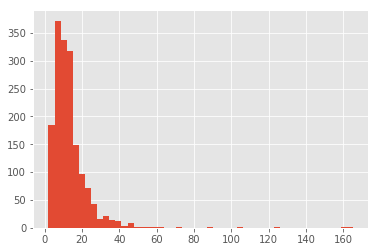

In [78]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

In [79]:
print('Max sentence length:',len(max(train_sentences+val_sentences, key=len)))

Max sentence length: 165


To improve speed we will use a MAX_SEQUENCE_LENGTH shorter than the max lengthed sentence. To avoid truncating sequences during padding we split our sentences to MAX_SEQUENCE_LENGTH and so the number of samples increases accordingly. For example, if MAX_SEQUENCE_LENGTH=70, a sentence with length 150 splits in 3 sentences: 150=70+70+10

In [80]:
def  split(sentences, max):
    new=[]
    for data in sentences:
        new.append(([data[x:x+max] for x in range(0, len(data), max)]))
    new = [val for sublist in new for val in sublist]
    return new

In [81]:
train_sentences = split(train_sentences, MAX_SEQUENCE_LENGTH)
val_sentences = split(val_sentences, MAX_SEQUENCE_LENGTH)
test_sentences = split(test_sentences, MAX_SEQUENCE_LENGTH)

In [82]:
len(max(train_sentences+val_sentences, key=len))

70

In [83]:
train_sentences = train_sentences + val_sentences

# BERT implementation

In [84]:
# Initialize session
sess = tf.Session()
# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1" #use multi lang version! 

In [85]:
train_text = text_sequence(train_sentences)
test_text = text_sequence(test_sentences)
#val_text = text_sequence(val_sentences)

train_label = tag_sequence(train_sentences)
test_label= tag_sequence(test_sentences)
#val_label= tag_sequence(val_sentences)

In [86]:
len(train_text)

1908

In [88]:
train_text[133], train_label[133]

(['„',
  'Йоанис',
  'идвал',
  'да',
  'подпомогне',
  'обсадените',
  'в',
  'Одрин',
  'с',
  'твърде',
  'голяма',
  'войска',
  ',',
  'защото',
  'той',
  'водел',
  'власи',
  'и',
  'българи',
  'и',
  'около',
  '14',
  '000',
  'кумани',
  ',',
  'които',
  'не',
  'били',
  'покръстени',
  '“',
  '—',
  'пише',
  'Вилардуен',
  '.'],
 ['N',
  'N',
  'Y',
  'N',
  'Y',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'Y',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'Y',
  'N',
  'N',
  'N',
  'Y',
  'N',
  'N'])

# Functions used for BERT representation

In [89]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label_ids = [0] * max_seq_length
        return input_ids, input_mask, segment_ids, label_ids
    
    tokens_a = example.text_a
    if len(tokens_a) > max_seq_length-2:
        tokens_a = tokens_a[0 : (max_seq_length-2)]

# Token map will be an int -> int mapping between the `orig_tokens` index and
# the `bert_tokens` index.

# bert_tokens == ["[CLS]", "john", "johan", "##son", "'", "s", "house", "[SEP]"]
# orig_to_tok_map == [1, 2, 4, 6]   
    orig_to_tok_map = []              
    tokens = []
    segment_ids = []
    
    tokens.append("[CLS]")
    segment_ids.append(0)
    orig_to_tok_map.append(len(tokens)-1)
    #print(len(tokens_a))
    for token in tokens_a:       
        tokens.extend(tokenizer.tokenize(token))
        orig_to_tok_map.append(len(tokens)-1)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)
    orig_to_tok_map.append(len(tokens)-1)
    input_ids = tokenizer.convert_tokens_to_ids([tokens[i] for i in orig_to_tok_map])
    #print(len(orig_to_tok_map), len(tokens), len(input_ids), len(segment_ids)) #for debugging

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)
    
    label_ids = []
    labels = example.label
    label_ids.append(0)
    label_ids.extend([tag2int[label] for label in labels])
    label_ids.append(0)
    #print(len(label_ids)) #for debugging
    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
        label_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    assert len(label_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, label_ids

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text, text_b=None, label=label)
        )
    return InputExamples

In [90]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

W0411 18:19:42.880198 126028 module_wrapper.py:139] From c:\users\pnedelev\appdata\local\continuum\anaconda3\lib\site-packages\bert\tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



## Alignment code (token -> tag)

Following suggestions from WordPiece tokenization part in https://github.com/google-research/bert, for POS tagging task, input sentences are converted to the following format:

In [26]:
# orig_tokens = ["John", "Johanson", "'s",  "house"]
# labels      = ["NNP",  "NNP",      "POS", "NN"]
# bert_tokens = ['[CLS]", "john", "johan", "##son", "'",   "s",  "house", "[SEP]"]
# bert_labels = ['[CLS]", "NNP",  "NNP",   "##",    "POS", "##", "NN",    "[SEP]"] 

So, due to **Wordpiece** tokenizer we must take special care for the correct alignment of token to tag. This is done in function *convert_single_example(tokenizer, example, max_seq_length=256)* with the following piece of code:

In [91]:
def bert_labels(labels):
    train_label_bert = []
    train_label_bert.append('-PAD-')
    for i in labels:
        train_label_bert.append(i)
    train_label_bert.append('-PAD-')
    print('BERT labels:', train_label_bert)    

In [93]:
tokens_a = train_text[2]

In [95]:
orig_to_tok_map = []              
tokens = []
segment_ids = []
tokens.append("[CLS]")
segment_ids.append(0)
orig_to_tok_map.append(len(tokens)-1)
for token in tokens_a:
    #orig_to_tok_map.append(len(tokens)) # keep first piece of tokenized term
    tokens.extend(tokenizer.tokenize(token))
    orig_to_tok_map.append(len(tokens)-1) # # keep last piece of tokenized term -->> gives better results!
    segment_ids.append(0)
tokens.append("[SEP]")
segment_ids.append(0)
orig_to_tok_map.append(len(tokens)-1)
input_ids = tokenizer.convert_tokens_to_ids([tokens[i] for i in orig_to_tok_map])

In [96]:
print('Original tokens:',tokens_a)

Original tokens: ['Златото', 'е', 'подлудило', 'всички', '.']


In [97]:
print('BERT tokens:',tokens)

BERT tokens: ['[CLS]', 'З', '##лат', '##ото', 'е', 'под', '##лу', '##дил', '##о', 'всички', '.', '[SEP]']


In [98]:
bert_labels(train_label[2])

BERT labels: ['-PAD-', 'N', 'N', 'Y', 'N', 'N', '-PAD-']


In [99]:
orig_to_tok_map

[0, 3, 4, 8, 9, 10, 11]

In [100]:
print(input_ids)

[101, 19517, 546, 10316, 31425, 119, 102]


## Test the conversion of an example to BERT representation

In [101]:
"""Create InputExamples"""
InputExamples = []
for text, label in zip(train_text[0:1], train_label[0:1]):
    InputExamples.append(
        InputExample(guid=None, text_a=text, text_b=None, label=label)
)

In [102]:
input_ids, input_masks, segment_ids, labels = [], [], [], []
for example in tqdm_notebook(InputExamples, desc="Converting examples to features"):
    input_id, input_mask, segment_id, label = convert_single_example(
        tokenizer, example, MAX_SEQUENCE_LENGTH+2
    )
    input_ids.append(input_id)
    input_masks.append(input_mask)
    segment_ids.append(segment_id)
    labels.append(label)

## Convert examples to BERT representation

In [103]:
# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)

In [104]:
# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels_ids
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=MAX_SEQUENCE_LENGTH+2)
(test_input_ids, test_input_masks, test_segment_ids, test_labels_ids
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=MAX_SEQUENCE_LENGTH+2)

## See the form of BERT representation

In [105]:
print(len(train_input_ids[0]))
print(len(train_input_masks[0]))
print(len(train_segment_ids[0]))
print(len(train_labels_ids[0]))

72
72
72
72


In [106]:
train_input_ids[0]

array([  101,   164,   115, 29672,   100, 12184, 14614,   119,   166,
         102,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0])

In [107]:
train_input_masks[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [108]:
train_segment_ids[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [109]:
train_labels_ids[0]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [110]:
# One-hot encode labels
train_labels = to_categorical(train_labels_ids, num_classes=n_tags)
test_labels = to_categorical(test_labels_ids, num_classes=n_tags)

In [111]:
train_input_ids[0], train_labels[0]

(array([  101,   164,   115, 29672,   100, 12184, 14614,   119,   166,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1.,

## Model building

In [112]:
class BertLayer(Layer):
    def __init__(self, output_representation='sequence_output', trainable=True, **kwargs):
        self.bert = None
        super(BertLayer, self).__init__(**kwargs)
        
        self.trainable = trainable
        self.output_representation = output_representation

    def build(self, input_shape):
        # SetUp tensorflow Hub module
        self.bert = hub.Module(bert_path,
                               trainable=self.trainable, 
                               name="{}_module".format(self.name))

        # Assign module's trainable weights to model
        # Remove unused layers and set trainable parameters
        # s = ["/cls/", "/pooler/", 'layer_11', 'layer_10', 'layer_9', 'layer_8', 'layer_7', 'layer_6']
        s = ["/cls/", "/pooler/"]
        self.trainable_weights += [var for var in self.bert.variables[:] if not any(x in var.name for x in s)]
            
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
                
        # See Trainable Variables
        #tf.logging.info("**** Trainable Variables ****")
        #for var in self.trainable_weights:
        #    init_string = ", *INIT_FROM_CKPT*"
        #    tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape, init_string)
            
        print('Trainable weights:',len(self.trainable_weights))
        super(BertLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            self.output_representation
        ]
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs[0], 0.0)   

    def compute_output_shape(self, input_shape):
        if self.output_representation == 'pooled_output':
            return (None, 768)
        else:
            return (None, None, 768)

In [52]:
#del model

In [113]:
# Build model
def build_model(max_seq_length):
    seed = 0 
    in_id = keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    np.random.seed(seed)
    bert_output = BertLayer()(bert_inputs)

    np.random.seed(seed)
    outputs = keras.layers.Dense(n_tags, activation=keras.activations.softmax)(bert_output)

    np.random.seed(seed)
    model = keras.models.Model(inputs=bert_inputs, outputs=outputs)
    np.random.seed(seed)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.00004), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])   
    model.summary(100)
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [114]:
model = build_model(MAX_SEQUENCE_LENGTH+2) # We sum 2 for [CLS], [SEP] tokens

Trainable weights: 197


W0411 18:24:19.460079 126028 deprecation.py:506] From c:\users\pnedelev\appdata\local\continuum\anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_ids (InputLayer)           (None, 72)            0                                            
____________________________________________________________________________________________________
input_masks (InputLayer)         (None, 72)            0                                            
____________________________________________________________________________________________________
segment_ids (InputLayer)         (None, 72)            0                                            
____________________________________________________________________________________________________
bert_layer_1 (BertLayer)         (None, None, 768)     178565115   input_ids[0][0]                  
                                                                   input_m

In [115]:
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [116]:
train_input_ids.shape

(1908, 72)

In [117]:
train_input_masks.shape

(1908, 72)

In [118]:
train_segment_ids.shape

(1908, 72)

In [119]:
train_labels.shape

(1908, 72, 3)

## Model training (BERT fine-tuning)

In [120]:
initialize_vars(sess)

In [121]:
t_ini = datetime.datetime.now()

cp = ModelCheckpoint(filepath="bert_tagger.h5",
                     monitor='val_acc',
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=1)

early_stopping = EarlyStopping(monitor = 'val_acc', patience = 5)

history = model.fit([train_input_ids, train_input_masks, train_segment_ids], 
                    train_labels,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
                    #validation_split=0.3,
                    epochs=EPOCHS,
                    batch_size=16,
                    shuffle=True,
                    verbose=1,
                    callbacks=[cp, early_stopping]
                   ) 

t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

W0411 18:25:24.001424 126028 deprecation.py:323] From c:\users\pnedelev\appdata\local\continuum\anaconda3\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
c:\users\pnedelev\appdata\local\continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
W0411 18:25:51.783643 126028 module_wrapper.py:139] From c:\users\pnedelev\appdata\local\continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0411 18:25:51.786636 126028 module_wrapper.py:139

Train on 1908 samples, validate on 477 samples
Epoch 1/30
1908/1908 [==============================] - ETA: 52:04 - loss: 0.2790 - accuracy: 0.290 - ETA: 43:40 - loss: 0.2062 - accuracy: 0.502 - ETA: 39:20 - loss: 0.1793 - accuracy: 0.582 - ETA: 36:17 - loss: 0.1787 - accuracy: 0.633 - ETA: 34:40 - loss: 0.1680 - accuracy: 0.666 - ETA: 33:37 - loss: 0.1565 - accuracy: 0.709 - ETA: 32:29 - loss: 0.1482 - accuracy: 0.740 - ETA: 31:05 - loss: 0.1388 - accuracy: 0.766 - ETA: 29:54 - loss: 0.1312 - accuracy: 0.778 - ETA: 28:54 - loss: 0.1240 - accuracy: 0.789 - ETA: 28:11 - loss: 0.1171 - accuracy: 0.797 - ETA: 28:00 - loss: 0.1109 - accuracy: 0.807 - ETA: 27:30 - loss: 0.1079 - accuracy: 0.815 - ETA: 26:53 - loss: 0.1030 - accuracy: 0.822 - ETA: 26:21 - loss: 0.0983 - accuracy: 0.829 - ETA: 25:52 - loss: 0.0943 - accuracy: 0.836 - ETA: 25:26 - loss: 0.0913 - accuracy: 0.840 - ETA: 24:56 - loss: 0.0880 - accuracy: 0.845 - ETA: 24:34 - loss: 0.0851 - accuracy: 0.849 - ETA: 24:20 - loss: 0.08

c:\users\pnedelev\appdata\local\continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
c:\users\pnedelev\appdata\local\continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/30
1908/1908 [==============================] - ETA: 26:15 - loss: 0.0031 - accuracy: 0.996 - ETA: 25:12 - loss: 0.0046 - accuracy: 0.995 - ETA: 24:31 - loss: 0.0056 - accuracy: 0.993 - ETA: 23:47 - loss: 0.0051 - accuracy: 0.993 - ETA: 23:26 - loss: 0.0056 - accuracy: 0.992 - ETA: 23:31 - loss: 0.0069 - accuracy: 0.990 - ETA: 23:47 - loss: 0.0068 - accuracy: 0.989 - ETA: 23:47 - loss: 0.0070 - accuracy: 0.988 - ETA: 23:45 - loss: 0.0063 - accuracy: 0.989 - ETA: 23:18 - loss: 0.0061 - accuracy: 0.989 - ETA: 22:55 - loss: 0.0060 - accuracy: 0.989 - ETA: 22:28 - loss: 0.0057 - accuracy: 0.990 - ETA: 22:12 - loss: 0.0057 - accuracy: 0.990 - ETA: 21:55 - loss: 0.0054 - accuracy: 0.991 - ETA: 21:32 - loss: 0.0052 - accuracy: 0.991 - ETA: 21:18 - loss: 0.0050 - accuracy: 0.991 - ETA: 21:02 - loss: 0.0049 - accuracy: 0.991 - ETA: 20:45 - loss: 0.0050 - accuracy: 0.991 - ETA: 20:28 - loss: 0.0048 - accuracy: 0.991 - ETA: 20:15 - loss: 0.0051 - accuracy: 0.991 - ETA: 20:02 - loss: 0.005

1908/1908 [==============================] - ETA: 23:09 - loss: 0.0026 - accuracy: 0.984 - ETA: 22:59 - loss: 0.0015 - accuracy: 0.992 - ETA: 22:48 - loss: 0.0026 - accuracy: 0.993 - ETA: 22:47 - loss: 0.0021 - accuracy: 0.995 - ETA: 22:50 - loss: 0.0018 - accuracy: 0.996 - ETA: 22:37 - loss: 0.0016 - accuracy: 0.996 - ETA: 22:37 - loss: 0.0014 - accuracy: 0.997 - ETA: 22:23 - loss: 0.0015 - accuracy: 0.997 - ETA: 22:14 - loss: 0.0014 - accuracy: 0.997 - ETA: 22:00 - loss: 0.0015 - accuracy: 0.997 - ETA: 21:44 - loss: 0.0015 - accuracy: 0.997 - ETA: 21:28 - loss: 0.0014 - accuracy: 0.997 - ETA: 21:15 - loss: 0.0014 - accuracy: 0.998 - ETA: 21:05 - loss: 0.0015 - accuracy: 0.997 - ETA: 20:52 - loss: 0.0014 - accuracy: 0.997 - ETA: 20:39 - loss: 0.0019 - accuracy: 0.997 - ETA: 20:31 - loss: 0.0019 - accuracy: 0.997 - ETA: 20:18 - loss: 0.0020 - accuracy: 0.996 - ETA: 20:06 - loss: 0.0020 - accuracy: 0.996 - ETA: 19:54 - loss: 0.0021 - accuracy: 0.996 - ETA: 19:42 - loss: 0.0020 - accurac

1908/1908 [==============================] - ETA: 24:41 - loss: 6.2522e-04 - accuracy: 1.000 - ETA: 25:05 - loss: 3.8898e-04 - accuracy: 1.000 - ETA: 25:52 - loss: 2.7626e-04 - accuracy: 1.000 - ETA: 25:10 - loss: 4.7657e-04 - accuracy: 0.998 - ETA: 24:44 - loss: 4.0596e-04 - accuracy: 0.999 - ETA: 24:31 - loss: 5.7111e-04 - accuracy: 0.998 - ETA: 24:10 - loss: 9.3675e-04 - accuracy: 0.998 - ETA: 23:52 - loss: 8.6885e-04 - accuracy: 0.998 - ETA: 23:35 - loss: 9.5388e-04 - accuracy: 0.998 - ETA: 23:24 - loss: 9.4397e-04 - accuracy: 0.998 - ETA: 23:16 - loss: 0.0011 - accuracy: 0.9981    - ETA: 22:57 - loss: 0.0011 - accuracy: 0.998 - ETA: 22:39 - loss: 0.0010 - accuracy: 0.998 - ETA: 22:21 - loss: 9.4353e-04 - accuracy: 0.998 - ETA: 22:06 - loss: 9.4744e-04 - accuracy: 0.998 - ETA: 21:49 - loss: 8.9419e-04 - accuracy: 0.998 - ETA: 21:32 - loss: 8.7067e-04 - accuracy: 0.998 - ETA: 21:14 - loss: 8.8620e-04 - accuracy: 0.998 - ETA: 20:56 - loss: 8.4675e-04 - accuracy: 0.998 - ETA: 20:41 - 

1908/1908 [==============================] - ETA: 24:08 - loss: 1.8384e-04 - accuracy: 1.000 - ETA: 24:07 - loss: 1.3864e-04 - accuracy: 1.000 - ETA: 23:31 - loss: 2.8441e-04 - accuracy: 1.000 - ETA: 23:21 - loss: 2.4297e-04 - accuracy: 1.000 - ETA: 23:15 - loss: 2.1572e-04 - accuracy: 1.000 - ETA: 23:00 - loss: 1.9251e-04 - accuracy: 1.000 - ETA: 22:46 - loss: 1.7749e-04 - accuracy: 1.000 - ETA: 22:32 - loss: 4.5887e-04 - accuracy: 0.999 - ETA: 22:22 - loss: 4.1823e-04 - accuracy: 0.999 - ETA: 22:03 - loss: 3.8062e-04 - accuracy: 0.999 - ETA: 21:45 - loss: 3.6030e-04 - accuracy: 0.999 - ETA: 21:30 - loss: 3.3994e-04 - accuracy: 0.999 - ETA: 21:15 - loss: 3.2235e-04 - accuracy: 0.999 - ETA: 21:01 - loss: 3.0476e-04 - accuracy: 0.999 - ETA: 20:49 - loss: 2.9373e-04 - accuracy: 0.999 - ETA: 20:37 - loss: 2.8176e-04 - accuracy: 0.999 - ETA: 20:23 - loss: 3.1285e-04 - accuracy: 0.999 - ETA: 20:15 - loss: 3.2659e-04 - accuracy: 0.999 - ETA: 20:04 - loss: 3.6623e-04 - accuracy: 0.999 - ETA: 

1908/1908 [==============================] - ETA: 22:44 - loss: 1.3594e-04 - accuracy: 1.000 - ETA: 23:23 - loss: 8.6021e-05 - accuracy: 1.000 - ETA: 24:02 - loss: 9.6483e-05 - accuracy: 1.000 - ETA: 23:41 - loss: 1.1246e-04 - accuracy: 1.000 - ETA: 23:31 - loss: 1.5447e-04 - accuracy: 1.000 - ETA: 23:19 - loss: 1.9718e-04 - accuracy: 1.000 - ETA: 23:22 - loss: 1.9407e-04 - accuracy: 1.000 - ETA: 22:59 - loss: 1.8752e-04 - accuracy: 1.000 - ETA: 22:49 - loss: 1.7256e-04 - accuracy: 1.000 - ETA: 22:40 - loss: 1.5980e-04 - accuracy: 1.000 - ETA: 22:28 - loss: 1.5242e-04 - accuracy: 1.000 - ETA: 22:15 - loss: 1.4568e-04 - accuracy: 1.000 - ETA: 22:02 - loss: 1.6847e-04 - accuracy: 1.000 - ETA: 21:46 - loss: 1.5938e-04 - accuracy: 1.000 - ETA: 21:33 - loss: 1.6267e-04 - accuracy: 1.000 - ETA: 21:18 - loss: 1.5424e-04 - accuracy: 1.000 - ETA: 21:06 - loss: 1.4791e-04 - accuracy: 1.000 - ETA: 20:53 - loss: 1.4230e-04 - accuracy: 1.000 - ETA: 20:38 - loss: 1.8620e-04 - accuracy: 0.999 - ETA: 

1908/1908 [==============================] - ETA: 21:34 - loss: 0.0035 - accuracy: 0.992 - ETA: 22:16 - loss: 0.0024 - accuracy: 0.994 - ETA: 22:24 - loss: 0.0016 - accuracy: 0.996 - ETA: 22:28 - loss: 0.0013 - accuracy: 0.997 - ETA: 22:35 - loss: 0.0011 - accuracy: 0.997 - ETA: 22:51 - loss: 9.5497e-04 - accuracy: 0.997 - ETA: 22:53 - loss: 8.8803e-04 - accuracy: 0.998 - ETA: 22:52 - loss: 0.0011 - accuracy: 0.9975    - ETA: 22:55 - loss: 0.0010 - accuracy: 0.997 - ETA: 22:56 - loss: 9.4294e-04 - accuracy: 0.997 - ETA: 22:47 - loss: 8.6276e-04 - accuracy: 0.998 - ETA: 22:30 - loss: 8.0124e-04 - accuracy: 0.998 - ETA: 22:11 - loss: 9.9429e-04 - accuracy: 0.997 - ETA: 21:57 - loss: 0.0010 - accuracy: 0.9976    - ETA: 21:49 - loss: 0.0010 - accuracy: 0.997 - ETA: 21:33 - loss: 0.0010 - accuracy: 0.997 - ETA: 21:17 - loss: 0.0011 - accuracy: 0.997 - ETA: 21:03 - loss: 0.0011 - accuracy: 0.997 - ETA: 20:50 - loss: 0.0011 - accuracy: 0.997 - ETA: 20:38 - loss: 0.0010 - accuracy: 0.997 - ETA

1908/1908 [==============================] - ETA: 22:01 - loss: 1.3464e-04 - accuracy: 1.000 - ETA: 22:17 - loss: 3.8999e-04 - accuracy: 1.000 - ETA: 22:40 - loss: 7.3586e-04 - accuracy: 0.998 - ETA: 22:39 - loss: 0.0012 - accuracy: 0.9976    - ETA: 22:28 - loss: 0.0022 - accuracy: 0.995 - ETA: 22:21 - loss: 0.0024 - accuracy: 0.994 - ETA: 22:23 - loss: 0.0035 - accuracy: 0.993 - ETA: 22:16 - loss: 0.0034 - accuracy: 0.993 - ETA: 22:14 - loss: 0.0030 - accuracy: 0.993 - ETA: 21:59 - loss: 0.0028 - accuracy: 0.994 - ETA: 21:51 - loss: 0.0026 - accuracy: 0.995 - ETA: 21:39 - loss: 0.0026 - accuracy: 0.995 - ETA: 21:23 - loss: 0.0026 - accuracy: 0.995 - ETA: 21:10 - loss: 0.0032 - accuracy: 0.994 - ETA: 20:53 - loss: 0.0031 - accuracy: 0.994 - ETA: 20:41 - loss: 0.0029 - accuracy: 0.994 - ETA: 20:30 - loss: 0.0029 - accuracy: 0.994 - ETA: 20:17 - loss: 0.0028 - accuracy: 0.994 - ETA: 20:13 - loss: 0.0026 - accuracy: 0.994 - ETA: 20:01 - loss: 0.0026 - accuracy: 0.994 - ETA: 19:48 - loss: 

1908/1908 [==============================] - ETA: 23:47 - loss: 4.6602e-05 - accuracy: 1.000 - ETA: 23:32 - loss: 8.4938e-04 - accuracy: 0.998 - ETA: 23:24 - loss: 8.9729e-04 - accuracy: 0.998 - ETA: 23:07 - loss: 6.9630e-04 - accuracy: 0.999 - ETA: 23:03 - loss: 6.0795e-04 - accuracy: 0.999 - ETA: 22:40 - loss: 9.6127e-04 - accuracy: 0.998 - ETA: 22:26 - loss: 8.3567e-04 - accuracy: 0.998 - ETA: 22:17 - loss: 7.3398e-04 - accuracy: 0.998 - ETA: 22:03 - loss: 7.1501e-04 - accuracy: 0.999 - ETA: 21:47 - loss: 8.8437e-04 - accuracy: 0.998 - ETA: 21:32 - loss: 8.4712e-04 - accuracy: 0.998 - ETA: 21:17 - loss: 7.9624e-04 - accuracy: 0.998 - ETA: 21:06 - loss: 7.3594e-04 - accuracy: 0.999 - ETA: 20:58 - loss: 6.8635e-04 - accuracy: 0.999 - ETA: 20:44 - loss: 6.4234e-04 - accuracy: 0.999 - ETA: 20:37 - loss: 6.0474e-04 - accuracy: 0.999 - ETA: 20:25 - loss: 5.9486e-04 - accuracy: 0.999 - ETA: 20:15 - loss: 7.0018e-04 - accuracy: 0.999 - ETA: 20:02 - loss: 6.6512e-04 - accuracy: 0.999 - ETA: 

1908/1908 [==============================] - ETA: 27:33 - loss: 1.6948e-04 - accuracy: 1.000 - ETA: 26:37 - loss: 5.1438e-04 - accuracy: 1.000 - ETA: 25:53 - loss: 6.6580e-04 - accuracy: 0.998 - ETA: 25:29 - loss: 5.1914e-04 - accuracy: 0.999 - ETA: 24:56 - loss: 4.6590e-04 - accuracy: 0.999 - ETA: 24:17 - loss: 7.4924e-04 - accuracy: 0.998 - ETA: 23:52 - loss: 7.1689e-04 - accuracy: 0.998 - ETA: 23:36 - loss: 6.3157e-04 - accuracy: 0.999 - ETA: 23:19 - loss: 6.7010e-04 - accuracy: 0.998 - ETA: 23:11 - loss: 6.2521e-04 - accuracy: 0.998 - ETA: 23:07 - loss: 6.5611e-04 - accuracy: 0.998 - ETA: 22:56 - loss: 6.0388e-04 - accuracy: 0.999 - ETA: 22:50 - loss: 9.2374e-04 - accuracy: 0.998 - ETA: 22:46 - loss: 8.6755e-04 - accuracy: 0.998 - ETA: 22:30 - loss: 0.0011 - accuracy: 0.9984    - ETA: 22:12 - loss: 0.0011 - accuracy: 0.998 - ETA: 21:55 - loss: 0.0011 - accuracy: 0.998 - ETA: 21:39 - loss: 0.0011 - accuracy: 0.998 - ETA: 21:25 - loss: 0.0010 - accuracy: 0.998 - ETA: 21:12 - loss: 0.

1908/1908 [==============================] - ETA: 18:44 - loss: 5.5335e-04 - accuracy: 1.000 - ETA: 19:09 - loss: 3.8482e-04 - accuracy: 1.000 - ETA: 19:05 - loss: 3.5189e-04 - accuracy: 1.000 - ETA: 19:06 - loss: 3.3651e-04 - accuracy: 1.000 - ETA: 18:58 - loss: 2.8890e-04 - accuracy: 1.000 - ETA: 18:48 - loss: 2.5023e-04 - accuracy: 1.000 - ETA: 18:45 - loss: 2.2194e-04 - accuracy: 1.000 - ETA: 18:35 - loss: 2.0318e-04 - accuracy: 1.000 - ETA: 18:21 - loss: 1.8475e-04 - accuracy: 1.000 - ETA: 18:05 - loss: 2.3118e-04 - accuracy: 1.000 - ETA: 17:55 - loss: 3.8689e-04 - accuracy: 0.999 - ETA: 17:45 - loss: 3.5579e-04 - accuracy: 0.999 - ETA: 17:32 - loss: 4.4792e-04 - accuracy: 0.999 - ETA: 17:21 - loss: 4.2062e-04 - accuracy: 0.999 - ETA: 17:12 - loss: 3.9653e-04 - accuracy: 0.999 - ETA: 17:01 - loss: 3.7308e-04 - accuracy: 0.999 - ETA: 16:54 - loss: 7.4547e-04 - accuracy: 0.998 - ETA: 16:45 - loss: 7.0492e-04 - accuracy: 0.998 - ETA: 16:37 - loss: 6.8700e-04 - accuracy: 0.998 - ETA: 

1908/1908 [==============================] - ETA: 20:17 - loss: 3.1492e-04 - accuracy: 1.000 - ETA: 20:15 - loss: 2.5423e-04 - accuracy: 1.000 - ETA: 20:20 - loss: 2.5010e-04 - accuracy: 1.000 - ETA: 20:08 - loss: 2.5390e-04 - accuracy: 1.000 - ETA: 19:46 - loss: 2.4742e-04 - accuracy: 1.000 - ETA: 19:38 - loss: 0.0015 - accuracy: 0.9986    - ETA: 19:24 - loss: 0.0013 - accuracy: 0.998 - ETA: 19:05 - loss: 0.0011 - accuracy: 0.999 - ETA: 18:51 - loss: 0.0010 - accuracy: 0.999 - ETA: 18:38 - loss: 9.4906e-04 - accuracy: 0.999 - ETA: 18:24 - loss: 8.7924e-04 - accuracy: 0.999 - ETA: 18:12 - loss: 8.2264e-04 - accuracy: 0.999 - ETA: 18:02 - loss: 7.6943e-04 - accuracy: 0.999 - ETA: 17:50 - loss: 7.5021e-04 - accuracy: 0.999 - ETA: 17:45 - loss: 7.3000e-04 - accuracy: 0.999 - ETA: 17:36 - loss: 6.9318e-04 - accuracy: 0.999 - ETA: 17:24 - loss: 6.5821e-04 - accuracy: 0.999 - ETA: 17:13 - loss: 6.8877e-04 - accuracy: 0.999 - ETA: 17:02 - loss: 6.5697e-04 - accuracy: 0.999 - ETA: 16:49 - loss

1908/1908 [==============================] - ETA: 20:31 - loss: 0.0017 - accuracy: 0.995 - ETA: 19:38 - loss: 8.5288e-04 - accuracy: 0.997 - ETA: 19:27 - loss: 5.6989e-04 - accuracy: 0.998 - ETA: 19:15 - loss: 4.4696e-04 - accuracy: 0.998 - ETA: 19:07 - loss: 3.6096e-04 - accuracy: 0.999 - ETA: 19:08 - loss: 3.0248e-04 - accuracy: 0.999 - ETA: 18:56 - loss: 2.9447e-04 - accuracy: 0.999 - ETA: 18:49 - loss: 2.5825e-04 - accuracy: 0.999 - ETA: 18:38 - loss: 2.5202e-04 - accuracy: 0.999 - ETA: 18:27 - loss: 2.2715e-04 - accuracy: 0.999 - ETA: 18:14 - loss: 2.0701e-04 - accuracy: 0.999 - ETA: 18:01 - loss: 1.9065e-04 - accuracy: 0.999 - ETA: 17:53 - loss: 1.8051e-04 - accuracy: 0.999 - ETA: 17:40 - loss: 1.6792e-04 - accuracy: 0.999 - ETA: 17:33 - loss: 1.5708e-04 - accuracy: 0.999 - ETA: 17:28 - loss: 1.4971e-04 - accuracy: 0.999 - ETA: 17:23 - loss: 1.4215e-04 - accuracy: 0.999 - ETA: 17:16 - loss: 1.3472e-04 - accuracy: 0.999 - ETA: 17:07 - loss: 1.3171e-04 - accuracy: 0.999 - ETA: 17:0

1908/1908 [==============================] - ETA: 20:50 - loss: 3.3358e-06 - accuracy: 1.000 - ETA: 20:14 - loss: 3.4853e-06 - accuracy: 1.000 - ETA: 19:54 - loss: 4.3208e-06 - accuracy: 1.000 - ETA: 19:26 - loss: 4.4639e-06 - accuracy: 1.000 - ETA: 19:11 - loss: 3.8439e-06 - accuracy: 1.000 - ETA: 18:58 - loss: 4.3608e-06 - accuracy: 1.000 - ETA: 18:46 - loss: 4.2878e-06 - accuracy: 1.000 - ETA: 18:37 - loss: 5.8916e-06 - accuracy: 1.000 - ETA: 18:27 - loss: 5.4983e-06 - accuracy: 1.000 - ETA: 18:21 - loss: 7.3846e-06 - accuracy: 1.000 - ETA: 18:12 - loss: 6.9893e-06 - accuracy: 1.000 - ETA: 18:02 - loss: 7.6154e-06 - accuracy: 1.000 - ETA: 17:52 - loss: 7.4995e-06 - accuracy: 1.000 - ETA: 17:43 - loss: 7.9437e-06 - accuracy: 1.000 - ETA: 17:32 - loss: 7.9887e-06 - accuracy: 1.000 - ETA: 17:23 - loss: 7.8014e-06 - accuracy: 1.000 - ETA: 17:13 - loss: 9.6563e-06 - accuracy: 1.000 - ETA: 17:04 - loss: 9.3163e-06 - accuracy: 1.000 - ETA: 16:53 - loss: 9.0651e-06 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 19:29 - loss: 1.4622e-06 - accuracy: 1.000 - ETA: 19:47 - loss: 1.0676e-06 - accuracy: 1.000 - ETA: 19:38 - loss: 1.4740e-06 - accuracy: 1.000 - ETA: 19:27 - loss: 1.4654e-06 - accuracy: 1.000 - ETA: 19:16 - loss: 1.7554e-06 - accuracy: 1.000 - ETA: 19:09 - loss: 1.6461e-06 - accuracy: 1.000 - ETA: 19:03 - loss: 1.5654e-06 - accuracy: 1.000 - ETA: 18:55 - loss: 1.4662e-06 - accuracy: 1.000 - ETA: 18:46 - loss: 1.3920e-06 - accuracy: 1.000 - ETA: 18:36 - loss: 1.5988e-06 - accuracy: 1.000 - ETA: 18:24 - loss: 1.6999e-06 - accuracy: 1.000 - ETA: 18:17 - loss: 1.9311e-06 - accuracy: 1.000 - ETA: 18:04 - loss: 1.8228e-06 - accuracy: 1.000 - ETA: 17:52 - loss: 1.8473e-06 - accuracy: 1.000 - ETA: 17:40 - loss: 1.7653e-06 - accuracy: 1.000 - ETA: 17:26 - loss: 1.7107e-06 - accuracy: 1.000 - ETA: 17:15 - loss: 1.8172e-06 - accuracy: 1.000 - ETA: 17:05 - loss: 1.7826e-06 - accuracy: 1.000 - ETA: 16:53 - loss: 1.7404e-06 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 20:53 - loss: 8.7821e-07 - accuracy: 1.000 - ETA: 20:04 - loss: 1.0467e-06 - accuracy: 1.000 - ETA: 19:43 - loss: 1.0344e-06 - accuracy: 1.000 - ETA: 19:30 - loss: 1.0146e-06 - accuracy: 1.000 - ETA: 19:13 - loss: 1.0084e-06 - accuracy: 1.000 - ETA: 19:02 - loss: 9.4368e-07 - accuracy: 1.000 - ETA: 18:47 - loss: 1.0100e-06 - accuracy: 1.000 - ETA: 18:33 - loss: 1.0106e-06 - accuracy: 1.000 - ETA: 18:34 - loss: 1.1522e-06 - accuracy: 1.000 - ETA: 18:19 - loss: 1.1438e-06 - accuracy: 1.000 - ETA: 18:08 - loss: 1.1378e-06 - accuracy: 1.000 - ETA: 17:56 - loss: 1.1178e-06 - accuracy: 1.000 - ETA: 17:45 - loss: 1.2599e-06 - accuracy: 1.000 - ETA: 17:38 - loss: 1.2084e-06 - accuracy: 1.000 - ETA: 17:31 - loss: 1.2097e-06 - accuracy: 1.000 - ETA: 17:20 - loss: 1.2133e-06 - accuracy: 1.000 - ETA: 17:10 - loss: 1.2759e-06 - accuracy: 1.000 - ETA: 17:00 - loss: 1.2961e-06 - accuracy: 1.000 - ETA: 16:49 - loss: 1.2608e-06 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 19:31 - loss: 7.3945e-07 - accuracy: 1.000 - ETA: 19:19 - loss: 8.6570e-07 - accuracy: 1.000 - ETA: 19:25 - loss: 9.3509e-07 - accuracy: 1.000 - ETA: 19:19 - loss: 8.4924e-07 - accuracy: 1.000 - ETA: 19:20 - loss: 9.9594e-07 - accuracy: 1.000 - ETA: 19:11 - loss: 1.0051e-06 - accuracy: 1.000 - ETA: 19:02 - loss: 1.1684e-06 - accuracy: 1.000 - ETA: 18:49 - loss: 1.1325e-06 - accuracy: 1.000 - ETA: 18:40 - loss: 1.0644e-06 - accuracy: 1.000 - ETA: 18:30 - loss: 1.0557e-06 - accuracy: 1.000 - ETA: 18:25 - loss: 1.1545e-06 - accuracy: 1.000 - ETA: 18:15 - loss: 1.1579e-06 - accuracy: 1.000 - ETA: 18:07 - loss: 1.1270e-06 - accuracy: 1.000 - ETA: 17:54 - loss: 1.1286e-06 - accuracy: 1.000 - ETA: 17:43 - loss: 1.1184e-06 - accuracy: 1.000 - ETA: 17:31 - loss: 1.0790e-06 - accuracy: 1.000 - ETA: 17:20 - loss: 1.1152e-06 - accuracy: 1.000 - ETA: 17:08 - loss: 1.1144e-06 - accuracy: 1.000 - ETA: 16:59 - loss: 1.1108e-06 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 19:37 - loss: 5.1850e-07 - accuracy: 1.000 - ETA: 19:33 - loss: 6.4581e-07 - accuracy: 1.000 - ETA: 19:38 - loss: 7.3607e-07 - accuracy: 1.000 - ETA: 19:35 - loss: 7.6555e-07 - accuracy: 1.000 - ETA: 19:24 - loss: 8.9232e-07 - accuracy: 1.000 - ETA: 19:11 - loss: 9.7798e-07 - accuracy: 1.000 - ETA: 18:58 - loss: 9.1144e-07 - accuracy: 1.000 - ETA: 18:46 - loss: 8.5097e-07 - accuracy: 1.000 - ETA: 18:31 - loss: 8.3783e-07 - accuracy: 1.000 - ETA: 18:23 - loss: 8.2951e-07 - accuracy: 1.000 - ETA: 18:11 - loss: 7.9003e-07 - accuracy: 1.000 - ETA: 18:00 - loss: 8.1047e-07 - accuracy: 1.000 - ETA: 17:47 - loss: 7.9574e-07 - accuracy: 1.000 - ETA: 17:37 - loss: 7.8474e-07 - accuracy: 1.000 - ETA: 17:31 - loss: 7.6962e-07 - accuracy: 1.000 - ETA: 17:18 - loss: 8.0577e-07 - accuracy: 1.000 - ETA: 17:08 - loss: 7.9643e-07 - accuracy: 1.000 - ETA: 16:58 - loss: 7.6742e-07 - accuracy: 1.000 - ETA: 16:48 - loss: 7.7571e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 20:16 - loss: 3.2892e-07 - accuracy: 1.000 - ETA: 19:54 - loss: 4.0404e-07 - accuracy: 1.000 - ETA: 19:46 - loss: 3.7027e-07 - accuracy: 1.000 - ETA: 19:36 - loss: 3.9006e-07 - accuracy: 1.000 - ETA: 19:21 - loss: 3.6647e-07 - accuracy: 1.000 - ETA: 19:16 - loss: 3.7726e-07 - accuracy: 1.000 - ETA: 19:12 - loss: 5.6027e-07 - accuracy: 1.000 - ETA: 19:04 - loss: 5.6259e-07 - accuracy: 1.000 - ETA: 18:55 - loss: 5.3243e-07 - accuracy: 1.000 - ETA: 18:50 - loss: 6.3099e-07 - accuracy: 1.000 - ETA: 18:39 - loss: 6.5289e-07 - accuracy: 1.000 - ETA: 18:30 - loss: 6.9112e-07 - accuracy: 1.000 - ETA: 18:18 - loss: 6.7016e-07 - accuracy: 1.000 - ETA: 18:11 - loss: 6.4136e-07 - accuracy: 1.000 - ETA: 18:09 - loss: 6.4785e-07 - accuracy: 1.000 - ETA: 18:05 - loss: 6.2827e-07 - accuracy: 1.000 - ETA: 18:00 - loss: 6.3349e-07 - accuracy: 1.000 - ETA: 17:54 - loss: 6.1167e-07 - accuracy: 1.000 - ETA: 17:47 - loss: 6.1916e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 20:30 - loss: 2.4691e-07 - accuracy: 1.000 - ETA: 19:50 - loss: 2.9270e-07 - accuracy: 1.000 - ETA: 19:42 - loss: 3.4153e-07 - accuracy: 1.000 - ETA: 19:43 - loss: 4.3554e-07 - accuracy: 1.000 - ETA: 19:22 - loss: 4.0015e-07 - accuracy: 1.000 - ETA: 19:08 - loss: 4.2710e-07 - accuracy: 1.000 - ETA: 18:53 - loss: 4.7051e-07 - accuracy: 1.000 - ETA: 18:38 - loss: 4.9132e-07 - accuracy: 1.000 - ETA: 18:27 - loss: 5.2911e-07 - accuracy: 1.000 - ETA: 18:23 - loss: 5.2324e-07 - accuracy: 1.000 - ETA: 18:13 - loss: 5.4437e-07 - accuracy: 1.000 - ETA: 18:04 - loss: 5.7995e-07 - accuracy: 1.000 - ETA: 17:56 - loss: 5.5897e-07 - accuracy: 1.000 - ETA: 17:47 - loss: 5.5772e-07 - accuracy: 1.000 - ETA: 17:43 - loss: 5.7589e-07 - accuracy: 1.000 - ETA: 17:43 - loss: 5.7091e-07 - accuracy: 1.000 - ETA: 17:38 - loss: 5.9674e-07 - accuracy: 1.000 - ETA: 17:26 - loss: 6.2251e-07 - accuracy: 1.000 - ETA: 17:14 - loss: 6.3777e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 19:33 - loss: 2.0298e-07 - accuracy: 1.000 - ETA: 19:57 - loss: 8.4019e-07 - accuracy: 1.000 - ETA: 19:57 - loss: 7.2120e-07 - accuracy: 1.000 - ETA: 19:45 - loss: 6.9738e-07 - accuracy: 1.000 - ETA: 19:30 - loss: 6.3516e-07 - accuracy: 1.000 - ETA: 19:25 - loss: 6.2337e-07 - accuracy: 1.000 - ETA: 19:14 - loss: 6.4605e-07 - accuracy: 1.000 - ETA: 19:02 - loss: 5.8641e-07 - accuracy: 1.000 - ETA: 18:50 - loss: 5.9239e-07 - accuracy: 1.000 - ETA: 18:41 - loss: 5.9351e-07 - accuracy: 1.000 - ETA: 18:28 - loss: 5.6466e-07 - accuracy: 1.000 - ETA: 18:17 - loss: 5.9997e-07 - accuracy: 1.000 - ETA: 18:05 - loss: 5.9560e-07 - accuracy: 1.000 - ETA: 17:58 - loss: 6.1129e-07 - accuracy: 1.000 - ETA: 17:52 - loss: 5.9163e-07 - accuracy: 1.000 - ETA: 17:44 - loss: 5.9689e-07 - accuracy: 1.000 - ETA: 17:34 - loss: 5.9614e-07 - accuracy: 1.000 - ETA: 17:24 - loss: 5.6979e-07 - accuracy: 1.000 - ETA: 17:12 - loss: 5.7532e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 18:56 - loss: 3.9525e-07 - accuracy: 1.000 - ETA: 18:55 - loss: 3.4358e-07 - accuracy: 1.000 - ETA: 18:51 - loss: 3.8275e-07 - accuracy: 1.000 - ETA: 18:49 - loss: 3.6978e-07 - accuracy: 1.000 - ETA: 18:47 - loss: 3.9955e-07 - accuracy: 1.000 - ETA: 18:38 - loss: 3.7564e-07 - accuracy: 1.000 - ETA: 18:38 - loss: 3.5534e-07 - accuracy: 1.000 - ETA: 18:34 - loss: 3.6137e-07 - accuracy: 1.000 - ETA: 18:24 - loss: 3.5574e-07 - accuracy: 1.000 - ETA: 18:14 - loss: 3.4703e-07 - accuracy: 1.000 - ETA: 18:04 - loss: 3.4926e-07 - accuracy: 1.000 - ETA: 17:54 - loss: 4.2309e-07 - accuracy: 1.000 - ETA: 17:45 - loss: 4.2813e-07 - accuracy: 1.000 - ETA: 17:38 - loss: 4.2933e-07 - accuracy: 1.000 - ETA: 17:29 - loss: 4.1500e-07 - accuracy: 1.000 - ETA: 17:19 - loss: 4.1740e-07 - accuracy: 1.000 - ETA: 17:10 - loss: 4.2292e-07 - accuracy: 1.000 - ETA: 17:00 - loss: 4.1720e-07 - accuracy: 1.000 - ETA: 16:50 - loss: 4.1686e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 19:26 - loss: 5.9296e-07 - accuracy: 1.000 - ETA: 19:10 - loss: 4.4966e-07 - accuracy: 1.000 - ETA: 19:17 - loss: 5.0824e-07 - accuracy: 1.000 - ETA: 19:18 - loss: 5.1872e-07 - accuracy: 1.000 - ETA: 19:06 - loss: 5.3836e-07 - accuracy: 1.000 - ETA: 19:07 - loss: 5.7495e-07 - accuracy: 1.000 - ETA: 18:58 - loss: 5.1519e-07 - accuracy: 1.000 - ETA: 18:45 - loss: 4.9866e-07 - accuracy: 1.000 - ETA: 18:35 - loss: 4.9222e-07 - accuracy: 1.000 - ETA: 18:22 - loss: 5.4461e-07 - accuracy: 1.000 - ETA: 18:15 - loss: 5.4254e-07 - accuracy: 1.000 - ETA: 18:04 - loss: 5.2217e-07 - accuracy: 1.000 - ETA: 17:56 - loss: 5.2459e-07 - accuracy: 1.000 - ETA: 17:45 - loss: 5.1328e-07 - accuracy: 1.000 - ETA: 17:34 - loss: 4.8621e-07 - accuracy: 1.000 - ETA: 17:24 - loss: 4.7373e-07 - accuracy: 1.000 - ETA: 17:15 - loss: 4.5425e-07 - accuracy: 1.000 - ETA: 17:03 - loss: 4.3994e-07 - accuracy: 1.000 - ETA: 16:55 - loss: 4.2978e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 19:08 - loss: 3.5060e-07 - accuracy: 1.000 - ETA: 19:28 - loss: 3.3826e-07 - accuracy: 1.000 - ETA: 19:18 - loss: 3.2428e-07 - accuracy: 1.000 - ETA: 19:10 - loss: 2.8206e-07 - accuracy: 1.000 - ETA: 18:59 - loss: 2.9256e-07 - accuracy: 1.000 - ETA: 18:48 - loss: 2.6718e-07 - accuracy: 1.000 - ETA: 18:38 - loss: 3.2126e-07 - accuracy: 1.000 - ETA: 18:32 - loss: 3.1919e-07 - accuracy: 1.000 - ETA: 18:22 - loss: 3.0605e-07 - accuracy: 1.000 - ETA: 18:18 - loss: 2.9786e-07 - accuracy: 1.000 - ETA: 18:14 - loss: 3.2391e-07 - accuracy: 1.000 - ETA: 18:06 - loss: 3.3254e-07 - accuracy: 1.000 - ETA: 17:55 - loss: 3.4317e-07 - accuracy: 1.000 - ETA: 17:44 - loss: 3.6820e-07 - accuracy: 1.000 - ETA: 17:33 - loss: 3.7920e-07 - accuracy: 1.000 - ETA: 17:22 - loss: 3.8190e-07 - accuracy: 1.000 - ETA: 17:14 - loss: 3.7313e-07 - accuracy: 1.000 - ETA: 17:06 - loss: 3.6744e-07 - accuracy: 1.000 - ETA: 16:56 - loss: 3.6615e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 19:40 - loss: 3.7813e-07 - accuracy: 1.000 - ETA: 19:36 - loss: 4.2206e-07 - accuracy: 1.000 - ETA: 19:27 - loss: 3.8642e-07 - accuracy: 1.000 - ETA: 19:07 - loss: 3.3970e-07 - accuracy: 1.000 - ETA: 19:03 - loss: 3.1946e-07 - accuracy: 1.000 - ETA: 18:53 - loss: 3.2263e-07 - accuracy: 1.000 - ETA: 18:50 - loss: 4.0617e-07 - accuracy: 1.000 - ETA: 18:47 - loss: 3.8036e-07 - accuracy: 1.000 - ETA: 18:40 - loss: 3.5828e-07 - accuracy: 1.000 - ETA: 18:30 - loss: 3.3664e-07 - accuracy: 1.000 - ETA: 18:19 - loss: 3.5100e-07 - accuracy: 1.000 - ETA: 18:06 - loss: 3.3966e-07 - accuracy: 1.000 - ETA: 17:53 - loss: 3.3353e-07 - accuracy: 1.000 - ETA: 17:41 - loss: 3.1953e-07 - accuracy: 1.000 - ETA: 17:31 - loss: 3.3009e-07 - accuracy: 1.000 - ETA: 17:20 - loss: 3.2519e-07 - accuracy: 1.000 - ETA: 17:09 - loss: 3.1667e-07 - accuracy: 1.000 - ETA: 16:57 - loss: 3.0725e-07 - accuracy: 1.000 - ETA: 16:47 - loss: 3.0186e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 19:07 - loss: 3.9666e-07 - accuracy: 1.000 - ETA: 19:19 - loss: 3.0755e-07 - accuracy: 1.000 - ETA: 19:24 - loss: 2.9408e-07 - accuracy: 1.000 - ETA: 19:14 - loss: 3.4148e-07 - accuracy: 1.000 - ETA: 19:05 - loss: 3.1981e-07 - accuracy: 1.000 - ETA: 18:55 - loss: 3.0413e-07 - accuracy: 1.000 - ETA: 18:54 - loss: 3.6420e-07 - accuracy: 1.000 - ETA: 18:47 - loss: 3.4953e-07 - accuracy: 1.000 - ETA: 18:42 - loss: 3.2749e-07 - accuracy: 1.000 - ETA: 18:37 - loss: 3.1547e-07 - accuracy: 1.000 - ETA: 18:28 - loss: 3.2439e-07 - accuracy: 1.000 - ETA: 18:17 - loss: 3.3855e-07 - accuracy: 1.000 - ETA: 18:10 - loss: 3.3620e-07 - accuracy: 1.000 - ETA: 18:06 - loss: 3.3921e-07 - accuracy: 1.000 - ETA: 17:57 - loss: 3.2735e-07 - accuracy: 1.000 - ETA: 17:46 - loss: 3.1817e-07 - accuracy: 1.000 - ETA: 17:38 - loss: 3.1332e-07 - accuracy: 1.000 - ETA: 17:28 - loss: 3.0577e-07 - accuracy: 1.000 - ETA: 17:17 - loss: 3.0460e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 21:57 - loss: 1.1874e-07 - accuracy: 1.000 - ETA: 21:20 - loss: 2.0994e-07 - accuracy: 1.000 - ETA: 21:05 - loss: 2.0041e-07 - accuracy: 1.000 - ETA: 20:57 - loss: 1.9954e-07 - accuracy: 1.000 - ETA: 20:51 - loss: 2.0877e-07 - accuracy: 1.000 - ETA: 20:47 - loss: 1.9317e-07 - accuracy: 1.000 - ETA: 20:49 - loss: 1.8752e-07 - accuracy: 1.000 - ETA: 20:33 - loss: 1.9537e-07 - accuracy: 1.000 - ETA: 20:14 - loss: 1.8227e-07 - accuracy: 1.000 - ETA: 19:53 - loss: 1.7828e-07 - accuracy: 1.000 - ETA: 19:36 - loss: 1.7565e-07 - accuracy: 1.000 - ETA: 19:18 - loss: 1.8070e-07 - accuracy: 1.000 - ETA: 19:01 - loss: 1.8415e-07 - accuracy: 1.000 - ETA: 18:44 - loss: 2.1388e-07 - accuracy: 1.000 - ETA: 18:32 - loss: 2.2184e-07 - accuracy: 1.000 - ETA: 18:18 - loss: 2.2027e-07 - accuracy: 1.000 - ETA: 18:05 - loss: 2.2128e-07 - accuracy: 1.000 - ETA: 17:49 - loss: 2.2185e-07 - accuracy: 1.000 - ETA: 17:40 - loss: 2.2198e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 20:21 - loss: 1.7840e-07 - accuracy: 1.000 - ETA: 20:16 - loss: 2.9161e-07 - accuracy: 1.000 - ETA: 20:03 - loss: 2.4691e-07 - accuracy: 1.000 - ETA: 19:43 - loss: 2.4207e-07 - accuracy: 1.000 - ETA: 19:24 - loss: 2.5325e-07 - accuracy: 1.000 - ETA: 19:07 - loss: 2.4598e-07 - accuracy: 1.000 - ETA: 18:56 - loss: 2.4489e-07 - accuracy: 1.000 - ETA: 18:49 - loss: 2.4145e-07 - accuracy: 1.000 - ETA: 18:32 - loss: 2.4975e-07 - accuracy: 1.000 - ETA: 18:23 - loss: 2.4237e-07 - accuracy: 1.000 - ETA: 18:11 - loss: 2.3253e-07 - accuracy: 1.000 - ETA: 18:00 - loss: 2.3855e-07 - accuracy: 1.000 - ETA: 17:48 - loss: 2.4446e-07 - accuracy: 1.000 - ETA: 17:39 - loss: 2.3583e-07 - accuracy: 1.000 - ETA: 17:30 - loss: 2.2562e-07 - accuracy: 1.000 - ETA: 17:19 - loss: 2.3140e-07 - accuracy: 1.000 - ETA: 17:08 - loss: 2.2727e-07 - accuracy: 1.000 - ETA: 16:56 - loss: 2.2578e-07 - accuracy: 1.000 - ETA: 16:47 - loss: 2.2728e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 19:04 - loss: 2.0981e-07 - accuracy: 1.000 - ETA: 19:30 - loss: 1.5072e-07 - accuracy: 1.000 - ETA: 19:25 - loss: 1.4679e-07 - accuracy: 1.000 - ETA: 19:23 - loss: 1.7651e-07 - accuracy: 1.000 - ETA: 19:11 - loss: 1.7216e-07 - accuracy: 1.000 - ETA: 19:02 - loss: 1.8602e-07 - accuracy: 1.000 - ETA: 18:51 - loss: 1.9303e-07 - accuracy: 1.000 - ETA: 18:42 - loss: 1.9763e-07 - accuracy: 1.000 - ETA: 18:30 - loss: 2.2123e-07 - accuracy: 1.000 - ETA: 18:22 - loss: 2.1420e-07 - accuracy: 1.000 - ETA: 18:12 - loss: 2.4166e-07 - accuracy: 1.000 - ETA: 18:00 - loss: 2.3971e-07 - accuracy: 1.000 - ETA: 17:49 - loss: 2.3841e-07 - accuracy: 1.000 - ETA: 17:39 - loss: 2.3002e-07 - accuracy: 1.000 - ETA: 17:26 - loss: 2.2700e-07 - accuracy: 1.000 - ETA: 17:15 - loss: 2.2266e-07 - accuracy: 1.000 - ETA: 17:04 - loss: 2.1772e-07 - accuracy: 1.000 - ETA: 16:54 - loss: 2.1586e-07 - accuracy: 1.000 - ETA: 16:43 - loss: 2.1070e-07 - accuracy: 1.000 - ETA: 

1908/1908 [==============================] - ETA: 20:13 - loss: 1.8296e-07 - accuracy: 1.000 - ETA: 19:58 - loss: 1.4436e-07 - accuracy: 1.000 - ETA: 20:00 - loss: 1.1905e-07 - accuracy: 1.000 - ETA: 19:38 - loss: 1.5478e-07 - accuracy: 1.000 - ETA: 19:25 - loss: 1.6866e-07 - accuracy: 1.000 - ETA: 19:11 - loss: 1.7170e-07 - accuracy: 1.000 - ETA: 19:00 - loss: 1.5697e-07 - accuracy: 1.000 - ETA: 18:46 - loss: 1.4688e-07 - accuracy: 1.000 - ETA: 18:33 - loss: 1.5147e-07 - accuracy: 1.000 - ETA: 18:20 - loss: 1.5397e-07 - accuracy: 1.000 - ETA: 18:09 - loss: 1.5380e-07 - accuracy: 1.000 - ETA: 17:57 - loss: 1.4911e-07 - accuracy: 1.000 - ETA: 17:47 - loss: 1.6013e-07 - accuracy: 1.000 - ETA: 17:35 - loss: 1.6737e-07 - accuracy: 1.000 - ETA: 17:25 - loss: 1.6164e-07 - accuracy: 1.000 - ETA: 17:14 - loss: 1.5721e-07 - accuracy: 1.000 - ETA: 17:05 - loss: 1.5915e-07 - accuracy: 1.000 - ETA: 16:56 - loss: 1.5735e-07 - accuracy: 1.000 - ETA: 16:48 - loss: 1.5470e-07 - accuracy: 1.000 - ETA: 

In [122]:
model.save_weights('bert_tagger2.h5')

## Classification report

In [124]:
model = build_model(MAX_SEQUENCE_LENGTH+2) 
model.load_weights('bert_tagger2.h5')

Trainable weights: 197
Model: "model_3"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_ids (InputLayer)           (None, 72)            0                                            
____________________________________________________________________________________________________
input_masks (InputLayer)         (None, 72)            0                                            
____________________________________________________________________________________________________
segment_ids (InputLayer)         (None, 72)            0                                            
____________________________________________________________________________________________________
bert_layer_3 (BertLayer)         (None, None, 768)     178565115   input_ids[0][0]                  
                                                   

In [125]:
y_pred = model.predict([test_input_ids, test_input_masks, test_segment_ids]).argmax(-1)
y_true = test_labels.argmax(-1)

W0412 10:45:04.443657 126028 module_wrapper.py:139] From c:\users\pnedelev\appdata\local\continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:438: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



In [126]:
y_true[0]

array([0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [127]:
def y2label(zipped, mask=0):
    out_true = []
    out_pred = []
    for zip_i in zipped:
        a, b = tuple(zip_i)
        if a != mask :
            out_true.append(int2tag[a])
            out_pred.append(int2tag[b])
    return out_true, out_pred

In [128]:
y_zipped = zip(y_true.flat, y_pred.flat)
y_true, y_pred = y2label(y_zipped)

In [129]:
len(y_true), len(y_pred)

(6198, 6198)

In [130]:
name='Bert fine-tuned model'
print('\n------------ Result of {} ----------\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))


------------ Result of Bert fine-tuned model ----------

              precision    recall  f1-score   support

       -PAD-     0.0000    0.0000    0.0000         0
           N     0.9921    0.9923    0.9922      5587
           Y     0.9310    0.9280    0.9295       611

    accuracy                         0.9860      6198
   macro avg     0.6411    0.6401    0.6406      6198
weighted avg     0.9861    0.9860    0.9860      6198



In [131]:
print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))

Accuracy: 0.9860
f1-macro score: 0.6406


## Confusion matrix

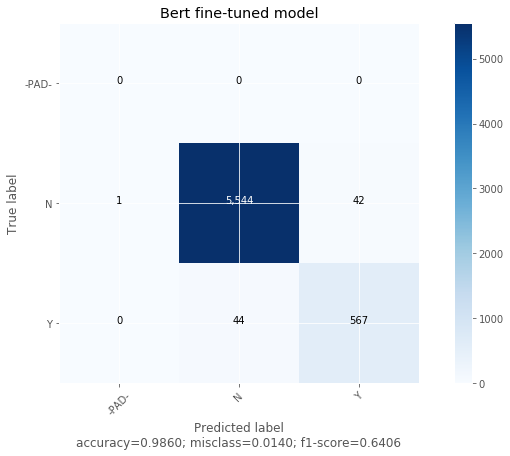

In [132]:
tags = sorted(set(y_pred+y_true))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(f1_score(y_true, y_pred, average='macro'), cnf_matrix, target_names=tags, title=name, normalize=False)

## Make a prediction for a test sample:

In [133]:
y_pred = model.predict([test_input_ids, test_input_masks, test_segment_ids], batch_size=16).argmax(-1)
y_true = test_labels_ids

def make_prediction(i=16):
    note = ''
    sent = []
    print("{:10} {:5} : {:5}".format("Word", "True", "Predicted"))
    print(35*'-')
    for w, true, pred in zip(test_input_ids[i], y_true[i], y_pred[i]):
        if tokenizer.convert_ids_to_tokens([w])[0]!='[PAD]' and \
            tokenizer.convert_ids_to_tokens([w])[0]!='[CLS]' and \
            tokenizer.convert_ids_to_tokens([w])[0]!='[SEP]':
            if int2tag[true] != int2tag[pred]: note='<<--- Error!'
            print("{:10} {:5} : {:5} {:5}".format(tokenizer.convert_ids_to_tokens([w])[0], int2tag[true], int2tag[pred], note))
            note=''

In [137]:
make_prediction(i=14)

Word       True  : Predicted
-----------------------------------
##ки       N     : N          
##рски     N     : N          
##ци       N     : N          
се         N     : N          
##ват      Y     : Y          
от         N     : N          
##то       N     : N          
място      N     : N          
и          N     : N          
##ят       Y     : N     <<--- Error!
на         N     : N          
##яг       N     : N          
.          N     : N          


## Tag an unknown sentence

In [218]:
sentences_raw = 'Статиите в Уикипедия често са цитирани както от медиите, така и в академичните среди: големите ѝ предимства са нейното свободно разпространение и списване, както и широкият ѝ обхват на теми. Редакторите са насърчавани да се придържат към политиката на „Неутрална гледна точка“, съгласно която основните възгледи по даден проблем се обобщават без опит да се изведе обективна истина. Така или иначе, славата на Уикипедия като достоверен справочник е оспорвана. Отворената ѝ природа позволява вандализъм, неточности, непридържане към приетите норми, ниско качество и пристрастия. Уикипедия – в сравнение с традиционните енциклопедии – е окачествявана като смесица от „истина, полуистина и някои лъжи“[3] и е критикувана за предпочитането на консенсуса пред личните авторитети и за предполагаемата липса на лична отговорност за съдържанието. Упреквана е също, че предоставя средство за безогледна манипулация и пропаганда, особено по спорни теми.[4]. От друга страна, към 2020 г. Уикипедия се оценявана като последното останало добро място в интернет[5], носител на културни иновации, който е несравнимо по-лесно достъпен и четен от традиционните хартиени енциклопедии. Същият автор високо оценява окуражаването на всякакви дискусии и възприемането на шеговит стил на общуване, напомнящ за ранните дни на Просвещението и първата Енциклопедия.'

In [219]:
# sentences = [word_tokenize(s) for s in sent_tokenize(raw_file)]
for sentence_raw in sent_tokenize(sentences_raw):
    

    sentence_ini = nltk.word_tokenize(sentence_raw)

    sentence_bert = tokenizer.tokenize(sentence_raw)

    tokens_a = sentence_ini

    orig_to_tok_map = []              
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    orig_to_tok_map.append(len(tokens)-1)
    for token in tokens_a:
        #orig_to_tok_map.append(len(tokens)) # keep first piece of tokenized term
        tokens.extend(tokenizer.tokenize(token))
        orig_to_tok_map.append(len(tokens)-1) # # keep last piece of tokenized term -->> gives better results!
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)
    orig_to_tok_map.append(len(tokens)-1)
    input_ids = tokenizer.convert_tokens_to_ids([tokens[i] for i in orig_to_tok_map])

    # print('Original tokens:',tokens_a)

    # print('BERT tokens:',tokens)

    # orig_to_tok_map

    [tokens[i] for i in orig_to_tok_map]

    # Convert data to InputExample format
    test_example = convert_text_to_examples([sentence_ini], [['-PAD-']*len(sentence_ini)])

    # Convert to features
    (input_ids, input_masks, segment_ids, _
    ) = convert_examples_to_features(tokenizer, test_example, max_seq_length=MAX_SEQUENCE_LENGTH+2)

    predictions = model.predict([input_ids, input_masks, segment_ids], batch_size=1).argmax(-1)[0]
    print("\n{:20}| {:15}: {:15}".format("Word in BERT layer", 'Initial word', "Predicted POS-tag"))
    print(61*'-')
    k = 0
    for i, pred in enumerate(predictions):
        try:
            if pred!=0:
                print("{:20}| {:15}: {:15}".format([tokens[i] for i in orig_to_tok_map][i], sentence_ini[i-1], int2tag[pred]))            
                k+=1            
        except:
            pass



Word in BERT layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
##ите               | Статиите       : N              
в                   | в              : N              
##педия             | Уикипедия      : N              
често               | често          : N              
са                  | са             : Y              
##рани              | цитирани       : N              
както               | както          : N              
от                  | от             : N              
##ите               | медиите        : N              
,                   | ,              : N              
така                | така           : N              
и                   | и              : N              
в                   | в              : N              
##чните             | академичните   : N              
среди               | среди          : N              
:                   | :              : N              



Word in BERT layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
##ите               | Редакторите    : N              
са                  | са             : Y              
##ни                | насърчавани    : N              
да                  | да             : N              
се                  | се             : N              
##т                 | придържат      : Y              
към                 | към            : N              
##та                | политиката     : N              
на                  | на             : N              
„                   | „              : N              
##на                | Неутрална      : N              
##една              | гледна         : N              
точка               | точка          : N              
[UNK]               | “              : N              
,                   | ,              : N              
##сно               | съгласно       : N              



Word in BERT layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
Така                | Така           : N              
или                 | или            : N              
иначе               | иначе          : N              
,                   | ,              : N              
##та                | славата        : N              
на                  | на             : N              
##педия             | Уикипедия      : N              
като                | като           : N              
##ерен              | достоверен     : N              
справочник          | справочник     : N              
е                   | е              : N              
##вана              | оспорвана      : N              
.                   | .              : N              




Word in BERT layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
##ената             | Отворената     : N              
ѝ                   | ѝ              : N              
##рода              | природа        : N              
##ва                | позволява      : Y              
##ъм                | вандализъм     : N              
,                   | ,              : N              
##сти               | неточности     : N              
,                   | ,              : N              
##не                | непридържане   : N              
към                 | към            : N              
##те                | приетите       : N              
##и                 | норми          : N              
,                   | ,              : N              
##ско               | ниско          : N              
##чество            | качество       : N              
и                   | и              : N              



Word in BERT layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
##педия             | Уикипедия      : N              
[UNK]               | –              : N              
в                   | в              : N              
##нение             | сравнение      : N              
с                   | с              : N              
##те                | традиционните  : N              
##дии               | енциклопедии   : N              
[UNK]               | –              : N              
е                   | е              : N              
##вана              | окачествявана  : N              
като                | като           : N              
##ца                | смесица        : N              
от                  | от             : N              
„                   | „              : N              
##на                | истина         : N              
,                   | ,              : N              



Word in BERT layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
##вана              | Упреквана      : N              
е                   | е              : N              
също                | също           : N              
,                   | ,              : N              
че                  | че             : N              
##я                 | предоставя     : Y              
средство            | средство       : N              
за                  | за             : N              
##дна               | безогледна     : N              
##ия                | манипулация    : N              
и                   | и              : N              
##ганда             | пропаганда     : N              
,                   | ,              : N              
особено             | особено        : N              
по                  | по             : N              
##ни                | спорни         : N              



Word in BERT layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
От                  | От             : N              
друга               | друга          : N              
страна              | страна         : N              
,                   | ,              : N              
към                 | към            : N              
2020                | 2020           : N              
.                   | г.             : N              
##педия             | Уикипедия      : N              
се                  | се             : N              
##на                | оценявана      : Y              
като                | като           : N              
##то                | последното     : N              
##ло                | останало       : N              
добро               | добро          : N              
място               | място          : N              
в                   | в              : N              



Word in BERT layer  | Initial word   : Predicted POS-tag
-------------------------------------------------------------
##т                 | Същият         : N              
автор               | автор          : N              
високо              | високо         : N              
##ява               | оценява        : Y              
##нето              | окуражаването  : N              
на                  | на             : N              
##кви               | всякакви       : N              
##ии                | дискусии       : N              
и                   | и              : N              
##то                | възприемането  : N              
на                  | на             : N              
##т                 | шеговит        : N              
стил                | стил           : N              
на                  | на             : N              
##ване              | общуване       : N              
,                   | ,              : N              

## Frequent types of mistakes

In [126]:
def find_errors(X,y):
    error_counter = collections.Counter()
    support = 0
    for i in range(test_input_ids.shape[0]):
        for w, true, pred in zip(test_input_ids[i], y_true[i], y_pred[i]):
            if int2tag[true]!='-PAD-':
                if true != pred:
                    word = tokenizer.convert_ids_to_tokens([w])[0]
                    error_counter[word] += 1
                support += 1
    return error_counter, support

In [127]:
errors, support = find_errors([test_input_ids],y_true)

In [128]:
print('Total errors/Total words: {}/{} | Accuracy: {:.4}\n'.format(sum(errors.values()), support, 1-sum(errors.values())/support))
print('Most common errors:', errors.most_common(20))

Total errors/Total words: 93/3408 | Accuracy: 0.9727

Most common errors: [('as', 8), ('appointed', 5), ('to', 4), ('part', 3), ('justice', 3), ('general', 3), ('than', 2), ('contracting', 2), ('base', 2), ('around', 2), ('##s', 1), ('##r', 1), ('is', 1), ('that', 1), ('time', 1), ('set', 1), ('interested', 1), ('traveling', 1), ('japanese', 1), ('by', 1)]


## Learning curves

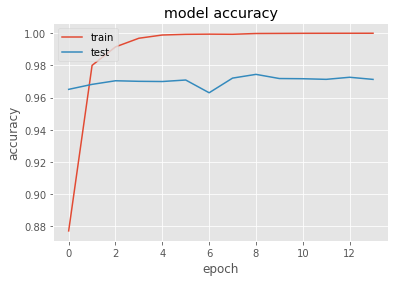

In [104]:
plot_acc()

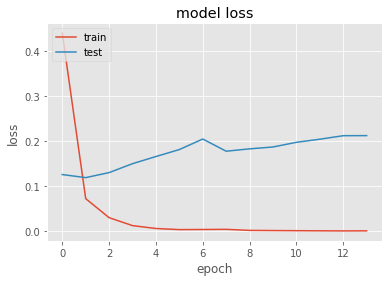

In [105]:
plot_loss()